In [53]:
import requests        # for making http requests to binance
import json            # for parsing what binance sends back to us
import pandas as pd    # for storing and manipulating the data we get back
import numpy as np     # numerical python, i usually need this somewhere 
                       # and so i import by habit nowadays

import matplotlib.pyplot as plt # for charts and such
import matplotlib.ticker as ticker

import itertools
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
from arch import arch_model

import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

import datetime as dt  # for dealing with times
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [2]:
### CARREGAR OS DFS
df_difficulty = pd.read_csv('datasets/blockchain_explorer/difficulty.csv',header = None, names=['time_stamp', 'difficulty'])
df_estimated_transaction_volume = pd.read_csv('datasets/blockchain_explorer/estimated-transaction-volume.csv',header = None, names=['time_stamp', 't_volume'])
df_hash_rate = pd.read_csv('datasets/blockchain_explorer/hash-rate.csv',header = None, names=['time_stamp', 'hash_rate'])
df_market_price = pd.read_csv('datasets/blockchain_explorer/market-price.csv',header = None, names=['time_stamp', 'market_price'])
df_mempool_coun = pd.read_csv('datasets/blockchain_explorer/mempool-count.csv',header = None, names=['time_stamp', 'mempool_count'])
df_mempool_size = pd.read_csv('datasets/blockchain_explorer/mempool-size.csv',header = None, names=['time_stamp', 'mempool_size'])
df_n_transactions = pd.read_csv('datasets/blockchain_explorer/n-transactions.csv',header = None, names=['time_stamp', 'n_transactions'])
df_transaction_fees = pd.read_csv('datasets/blockchain_explorer/transaction-fees.csv',header = None, names=['time_stamp', 'transaction-fees'])

In [3]:
### TRANSFORMA EM DATETIME
df_difficulty['time_stamp'] = pd.to_datetime(df_difficulty['time_stamp'])
df_estimated_transaction_volume['time_stamp'] = pd.to_datetime(df_estimated_transaction_volume['time_stamp'])
df_hash_rate['time_stamp'] = pd.to_datetime(df_hash_rate['time_stamp'])
df_market_price['time_stamp'] = pd.to_datetime(df_market_price['time_stamp'])
df_mempool_coun['time_stamp'] = pd.to_datetime(df_mempool_coun['time_stamp'])
df_mempool_size['time_stamp'] = pd.to_datetime(df_mempool_size['time_stamp'])
df_n_transactions['time_stamp'] = pd.to_datetime(df_n_transactions['time_stamp'])
df_transaction_fees['time_stamp'] = pd.to_datetime(df_transaction_fees['time_stamp'])

In [4]:
### VISUALIZA OS TEMPOS MAXIMO E MINIMO
print('------------', 'df_difficulty', '------------')
print(df_difficulty['time_stamp'].max())
print(df_difficulty['time_stamp'].min())
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume['time_stamp'].max())
print(df_estimated_transaction_volume['time_stamp'].min())
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate['time_stamp'].max())
print(df_hash_rate['time_stamp'].min())
print('------------', 'df_market_price', '------------')
print(df_market_price['time_stamp'].max())
print(df_market_price['time_stamp'].min())
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun['time_stamp'].max())
print(df_mempool_coun['time_stamp'].min())
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size['time_stamp'].max())
print(df_mempool_size['time_stamp'].min())
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions['time_stamp'].max())
print(df_n_transactions['time_stamp'].min())
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees['time_stamp'].max())
print(df_transaction_fees['time_stamp'].min())

------------ df_difficulty ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_estimated_transaction_volume ------------
2020-03-10 00:00:00
2010-08-28 00:00:00
------------ df_hash_rate ------------
2020-03-08 00:00:00
2009-01-03 00:00:00
------------ df_market_price ------------
2020-03-09 00:00:00
2009-01-03 00:00:00
------------ df_mempool_coun ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_mempool_size ------------
2020-03-10 11:30:00
2016-06-14 14:45:00
------------ df_n_transactions ------------
2020-03-08 00:00:00
2009-01-17 00:00:00
------------ df_transaction_fees ------------
2020-03-08 00:00:00
2009-01-17 00:00:00


In [5]:
### VISUALIZA O TAMANHO DOS DF
print('------------', 'df_difficulty', '------------')
print(df_difficulty.size)
print('------------', 'df_estimated_transaction_volume', '------------')
print(df_estimated_transaction_volume.size)
print('------------', 'df_hash_rate', '------------')
print(df_hash_rate.size)
print('------------', 'df_market_price', '------------')
print(df_market_price.size)
print('------------', 'df_mempool_coun', '------------')
print(df_mempool_coun.size)
print('------------', 'df_mempool_size', '------------')
print(df_mempool_size.size)
print('------------', 'df_n_transactions', '------------')
print(df_n_transactions.size)
print('------------', 'df_transaction_fees', '------------')
print(df_transaction_fees.size)

------------ df_difficulty ------------
2712
------------ df_estimated_transaction_volume ------------
3470
------------ df_hash_rate ------------
2712
------------ df_market_price ------------
2724
------------ df_mempool_coun ------------
3014
------------ df_mempool_size ------------
3014
------------ df_n_transactions ------------
2714
------------ df_transaction_fees ------------
2714


In [6]:
# df_difficulty
# df_estimated_transaction_volume
# df_hash_rate
# df_market_price
# df_mempool_coun # time stamp com horas, minutos e segundos
# df_mempool_size # time stamp com horas, minutos e segundos
# df_n_transactions
# df_transaction_fees

In [7]:
### JUNTA OS DATAFRAMES

def set_index(df):
    return df.set_index('time_stamp')
    
list_df = [df_market_price, df_difficulty, df_estimated_transaction_volume, df_hash_rate, df_n_transactions, df_transaction_fees]

for i in range(len(list_df)):
    list_df[i] = set_index(list_df[i])  

df_concat = pd.DataFrame([], index=pd.date_range(start='3/1/2009', end='3/10/2020'))
df_concat = df_concat.join(list_df, how = 'left')
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4028 entries, 2009-03-01 to 2020-03-10
Freq: D
Data columns (total 6 columns):
market_price        1343 non-null float64
difficulty          1337 non-null float64
t_volume            1735 non-null float64
hash_rate           1337 non-null float64
n_transactions      1342 non-null float64
transaction-fees    1342 non-null float64
dtypes: float64(6)
memory usage: 380.3 KB


In [8]:
print(df_concat.shape[0])
print(df_concat.dropna(how='all').shape[0])
df_concat.corr()

4028
3263


,market_price,difficulty,t_volume,hash_rate,n_transactions,transaction-fees
market_price,1.000000,0.804119,-0.107761,0.810384,NaN,NaN
difficulty,0.804119,1.000000,-0.129694,0.994801,0.223923,-0.224600
t_volume,-0.107761,-0.129694,1.000000,-0.128814,-0.009508,0.067692
hash_rate,0.810384,0.994801,-0.128814,1.000000,0.278332,-0.220753
n_transactions,NaN,0.223923,-0.009508,0.278332,1.000000,0.502042
transaction-fees,NaN,-0.224600,0.067692,-0.220753,0.502042,1.000000


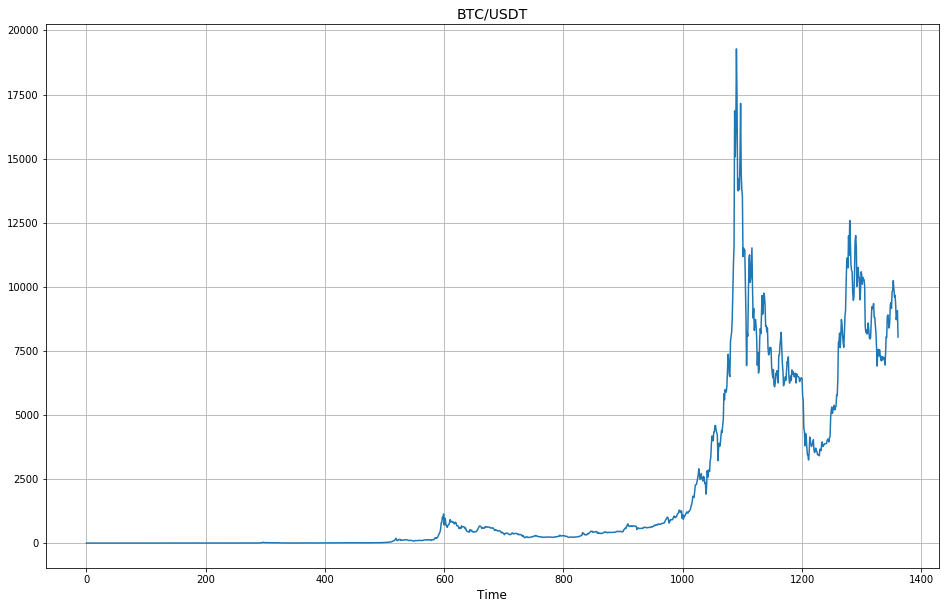

In [9]:
### TESTE GRAFICO
df = df_market_price.copy()

fig = plt.gcf()
fig.set_size_inches(16,10)
# sns.lineplot(x = 'market_price', y = 'difficulty',  data = df)
plt.plot(df['market_price'])
#plt.ylim(6000, 13000)
plt.title('BTC/USDT', fontsize = 14)
plt.xlabel('Time', fontsize = 12)
#plt.ylabel('difficulty', fontsize = 12)
plt.grid(True)
plt.show()

In [10]:
df.head()

,time_stamp,market_price
0,2009-01-03,0.0
1,2009-01-06,0.0
2,2009-01-09,0.0
3,2009-01-12,0.0
4,2009-01-15,0.0


In [11]:
# def _get_best_model(TS):
#     best_aic = np.inf 
#     best_order = None
#     best_mdl = None
#     pq_rng = range(5) # [0,1,2,3,4]
#     d_rng = range(2) # [0,1]
    
#     for i in pq_rng:
#         for d in d_rng:
#             for j in pq_rng:
#                 try:
#                     tmp_mdl = ARIMA(TS, order=(i,d,j)).fit(
#                         method='mle', trend='nc'
#                     )
#                     tmp_aic = tmp_mdl.aic
#                     if tmp_aic < best_aic:
#                         best_aic = tmp_aic
#                         best_order = (i, d, j)
#                         best_mdl = tmp_mdl
                        
#                 except: continue
#     print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
#     return best_aic, best_order, best_mdl
# TS = df['market_price']
# res_tup = _get_best_model(TS)

In [12]:
# order = res_tup[1]
# model = res_tup[2]
# print('order', order)
# print('model', model)

In [13]:
# sns.tsplot(model.resid)
# sm.graphics.tsa.plot_acf(model.resid, lags=40)
# sm.graphics.tsa.plot_pacf(model.resid, lags=40)
# plt.show()

In [14]:
# sns.tsplot(model.resid**2)
# sm.graphics.tsa.plot_acf(model.resid**2, lags=40)
# sm.graphics.tsa.plot_pacf(model.resid**2, lags=40)
# plt.show()

In [15]:
# p_ = order[0]
# o_ = order[1]
# q_ = order[2]

# am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
# res = am.fit(update_freq=5, disp='off')
# print(res.summary())

In [16]:
# # log returns
# lrets = np.log(df['market_price']/df['market_price'].shift(1)).dropna()

In [17]:
# windowLength = 1154
# foreLength = len(lrets) - windowLength
# signal = 0*lrets[-foreLength:]
# #print('foreLength', foreLength)
# #print('signal', signal)

In [18]:
# for d in range(foreLength):
    
#     # create a rolling window by selecting 
#     # values between d+1 and d+T of S&P500 returns
    
#     TS = lrets[(1+d):(windowLength+d)] 
    
#     # Find the best ARIMA fit 
#     # set d = 0 since we've already taken log return of the series
#     res_tup = _get_best_model(TS)
#     order = res_tup[1]
#     model = res_tup[2]
    
#     #now that we have our ARIMA fit, we feed this to GARCH model
#     p_ = order[0]
#     o_ = order[1]
#     q_ = order[2]
    
#     if (p_ == 0) & (o_ == 0):
#         o_ = 1
    
#     am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
#     res = am.fit(update_freq=5, disp='off')
    
#     # Generate a forecast of next day return using our fitted model
#     out = res.forecast(horizon=1, start=None, align='origin')
    
#     #Set trading signal equal to the sign of forecasted return
#     # Buy if we expect positive returns, sell if negative
      
#     signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

In [19]:
# signal_ = pd.DataFrame(signal).copy()
# returns = pd.DataFrame(index = signal_.index, 
#                        columns=['Buy and Hold', 'Strategy'])
# returns['Buy and Hold'] = lrets[-foreLength:]
# returns['Strategy'] = signal_['market_price']*returns['Buy and Hold']
# eqCurves = pd.DataFrame(index = signal_.index, 
#                        columns=['Buy and Hold', 'Strategy'])
# eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
# eqCurves['Strategy'] = returns['Strategy'].cumsum()+1
# eqCurves['Strategy'].plot(figsize=(10,8))
# eqCurves['Buy and Hold'].plot()
# plt.legend()
# plt.show()

# SARIMA TESTE

In [20]:
df = df_market_price.copy()
df.isnull().sum()

time_stamp      0
market_price    0
dtype: int64

In [21]:
df = df.set_index('time_stamp')
df.head()

,market_price
time_stamp,
2009-01-03,0.0
2009-01-06,0.0
2009-01-09,0.0
2009-01-12,0.0
2009-01-15,0.0


In [22]:
#filter irrelevant values
df = df['2013':]

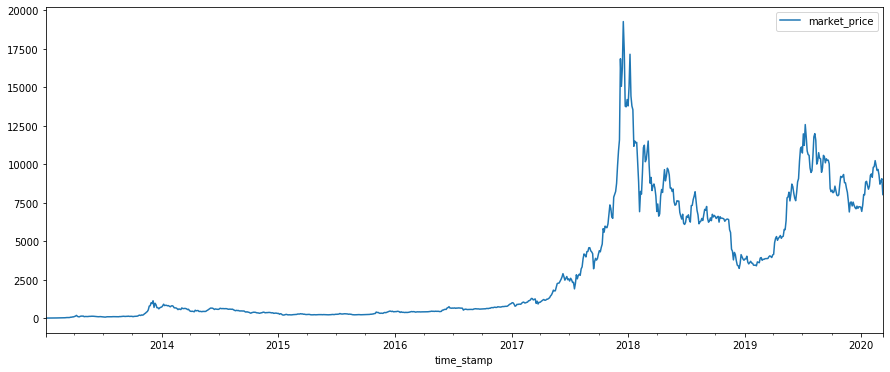

In [23]:
df.plot(figsize=(15, 6))
plt.show()

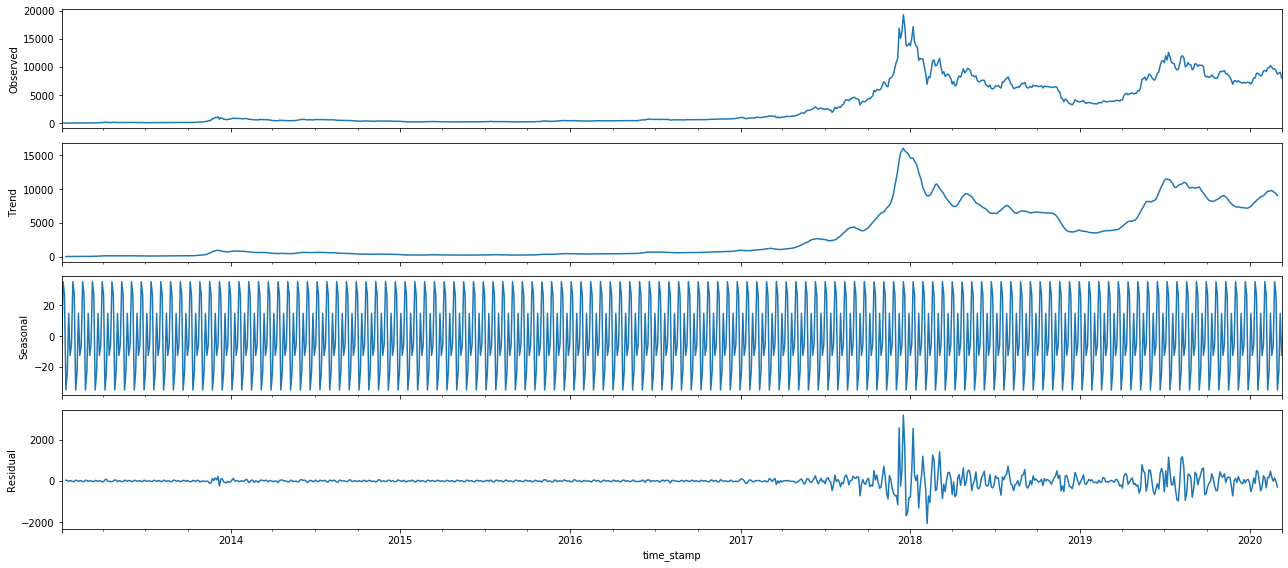

In [24]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('pdq', pdq)

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
pdq [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [26]:
best_aic = 90000
param_ = 0
param_seasonal_ = 0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    
            if results.aic < best_aic:
                best_aic = results.aic
                param_ = param
                param_seasonal_ = param_seasonal
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                
            
            
        except:
            continue
            
print('ideal', param_, param_seasonal_, best_aic)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14874.40585900646
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14046.06689056136
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12748.868483457212
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:12735.790578567265
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:12729.442158713047
ideal (1, 1, 1) (0, 0, 0, 12) 12729.442158713047


In [27]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6339      0.053    -11.923      0.000      -0.738      -0.530
ma.L1          0.7161      0.049     14.529      0.000       0.620       0.813
ar.S.L12      -0.0780      0.017     -4.478      0.000      -0.112      -0.044
ma.S.L12      -1.0000      0.011    -89.353      0.000      -1.022      -0.978
sigma2       1.82e+05   6.15e-08   2.96e+12      0.000    1.82e+05    1.82e+05


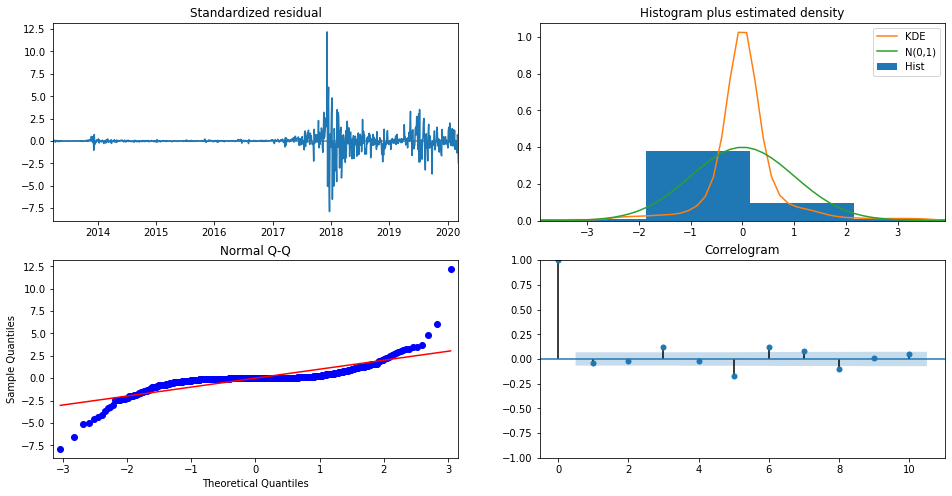

In [28]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

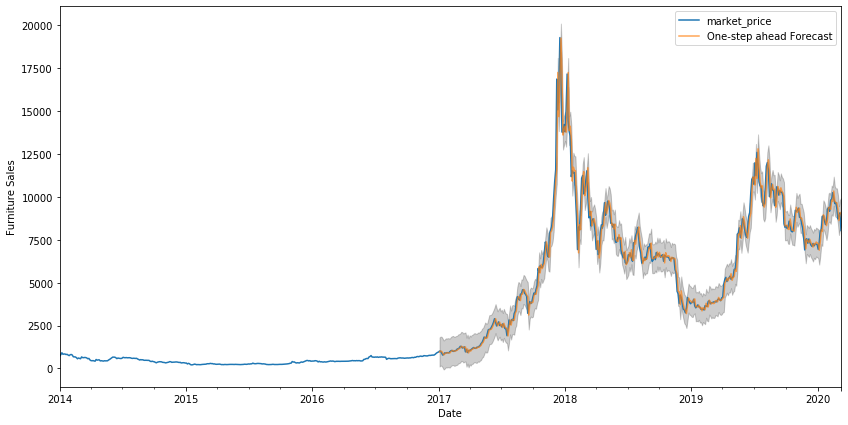

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-03'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [30]:
y_forecasted = pred.predicted_mean
y_truth = df['2017-01-03':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2017-01-03 00:00:00   NaN
2017-01-06 00:00:00   NaN
2017-01-09 00:00:00   NaN
2017-01-12 00:00:00   NaN
2017-01-15 00:00:00   NaN
                       ..
2020-02-29 00:00:00   NaN
2020-03-03 00:00:00   NaN
2020-03-06 00:00:00   NaN
2020-03-09 00:00:00   NaN
market_price          NaN
Length: 389, dtype: float64


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2017-01-03 00:00:00   NaN
2017-01-06 00:00:00   NaN
2017-01-09 00:00:00   NaN
2017-01-12 00:00:00   NaN
2017-01-15 00:00:00   NaN
                       ..
2020-02-29 00:00:00   NaN
2020-03-03 00:00:00   NaN
2020-03-06 00:00:00   NaN
2020-03-09 00:00:00   NaN
market_price          NaN
Length: 389, dtype: float64


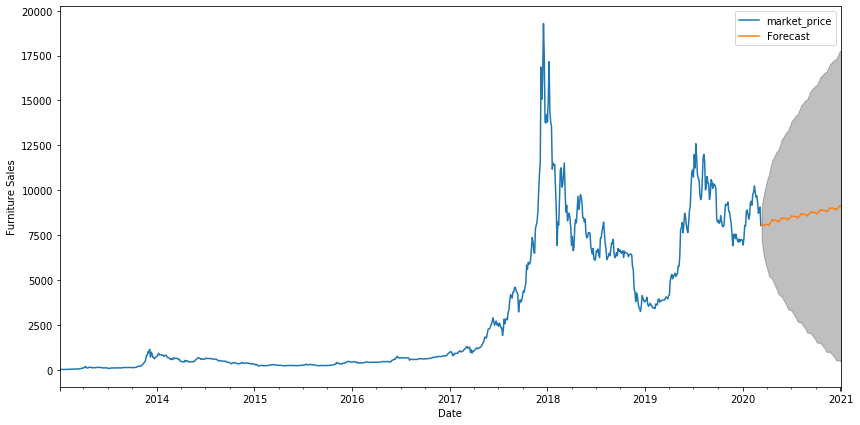

In [32]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# ARIMA TESTE

In [33]:
df = df_market_price.copy()
df.isnull().sum()

df = df.set_index('time_stamp')
df.head()

#filter irrelevant values
df = df['2013':]

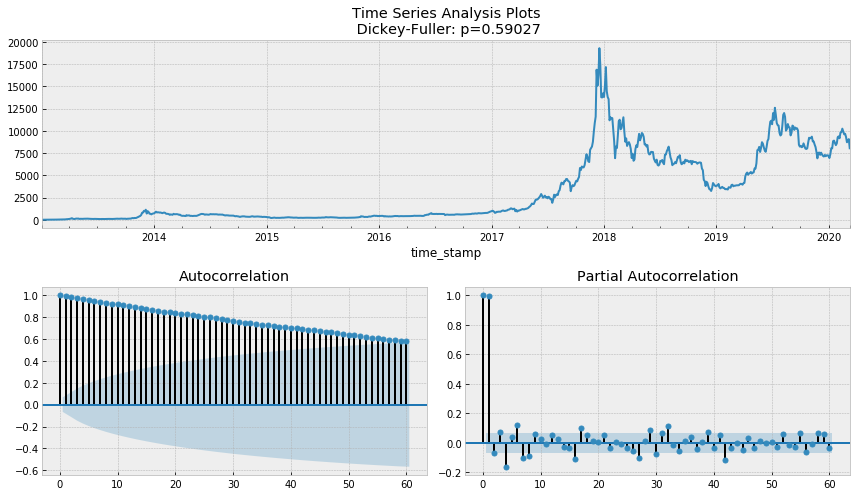

In [34]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df['market_price'], lags=60)

aic: 12980.14 | order: (2, 2, 4)


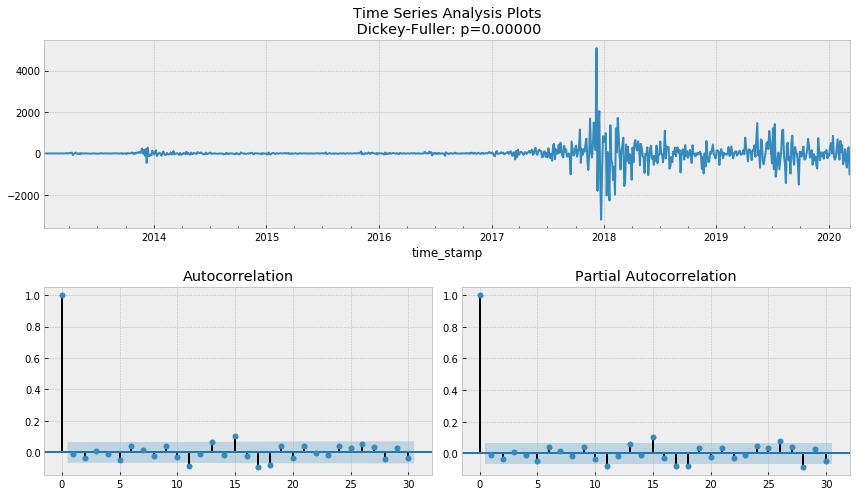

In [35]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(3) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(df, 
                                    order=(i,d,j)).fit(method='mle',
                                    trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.2f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [36]:
print(sm.stats.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False))

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('The residuals may not be normally distributed.')
else:
    print ('The residuals seem normally distributed.')

(array([44.14791193]), array([0.00143778]))
The residuals may not be normally distributed.


In [37]:
# end = '2019-03-05'
# start = '2017-01-01'
# symbols = ['market_price']
# #data = dl.load_data_nologs('nasdaq', symbols , start, end)['ADJ CLOSE']
# data = df[start:end][symbols]
# # log returns
# data_returns = np.log(data/data.shift(1)).dropna()

In [38]:
# # Fit ARIMA(p, d, q) model
# # pick best order and final model based on aic

# best_aic = np.inf 
# best_order = None
# best_mdl = None

# pq_rng = range(5) # [0,1,2,3]
# d_rng = range(3) # [0,1]
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = smt.ARIMA(data_returns, 
#                                     order=(i,d,j)).fit(method='mle',
#                                     trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except: continue


# print('aic: %6.2f | order: %s'%(best_aic, best_order))

# # ARIMA model resid plot
# _ = tsplot(best_mdl.resid, lags=30)

In [39]:
print(sm.stats.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False))

from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('The residuals may not be normally distributed.')
else:
    print ('The residuals seem normally distributed.')

(array([44.14791193]), array([0.00143778]))
The residuals may not be normally distributed.


In [40]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 100

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% 

idx = pd.date_range(df.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=
                     ['forecast', 'lower_95', 'upper_95'])

fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=
                     ['lower_99', 'upper_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_95,lower_99,upper_95,upper_99
2020-03-09,8194.142781,7401.197646,7152.036227,8987.087916,9236.249336
2020-03-10,8180.384755,7021.177467,6656.928138,9339.592044,9703.841373
2020-03-11,7865.168243,6410.246087,5953.076412,9320.090399,9777.260074
2020-03-12,8002.322152,6248.137136,5696.932255,9756.507168,10307.712048
2020-03-13,8265.577876,6286.152120,5664.171469,10245.003632,10866.984283


In [41]:
df.iloc[-1]

market_price    8039.38
Name: 2020-03-09 00:00:00, dtype: float64

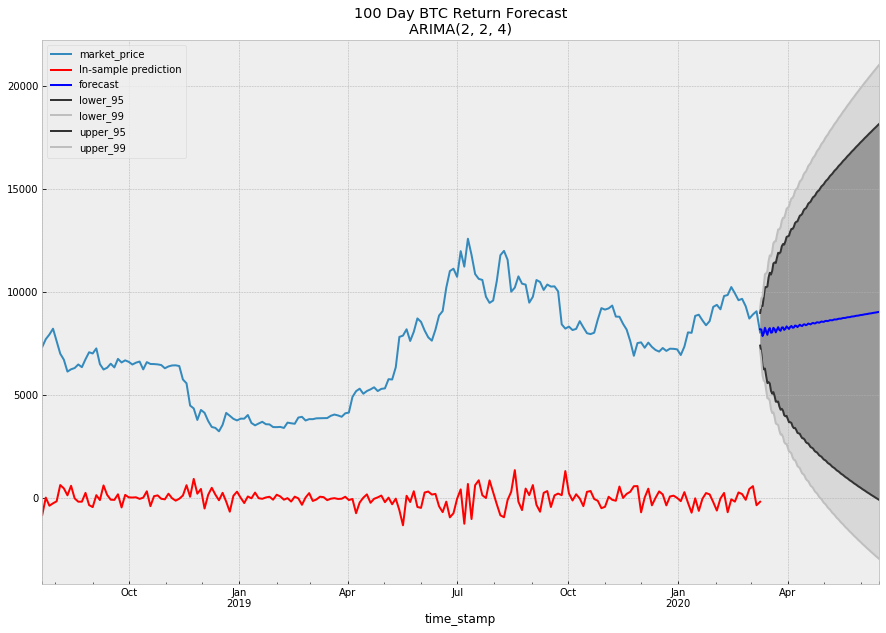

In [42]:
# Plot 21 day forecast for SPX returns
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ts = df.iloc[-200:].copy()
ts.plot(ax=ax, label='SPX Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')
styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_95, 
                 fc_all.upper_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_99, 
                 fc_all.upper_99, color='gray', alpha=0.2)
plt.title('{} Day BTC Return Forecast\nARIMA{}'.format(n_steps,
                 best_order))
plt.legend(loc='best', fontsize=10)

In [43]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(2, 2, 4),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3281      0.012    -26.922      0.000      -0.352      -0.304
ar.L2         -0.9011      0.012    -77.425      0.000      -0.924      -0.878
ma.L1         -0.6059      0.020    -30.809      0.000      -0.644      -0.567
ma.L2          0.5695      0.019     29.447      0.000       0.532       0.607
ma.L3         -0.7579      0.019    -39.650      0.000      -0.795      -0.720
ma.L4         -0.2043      0.016    -13.041      0.000      -0.235      -0.174
sigma2      1.883e+05   3510.795     53.628      0.000    1.81e+05    1.95e+05


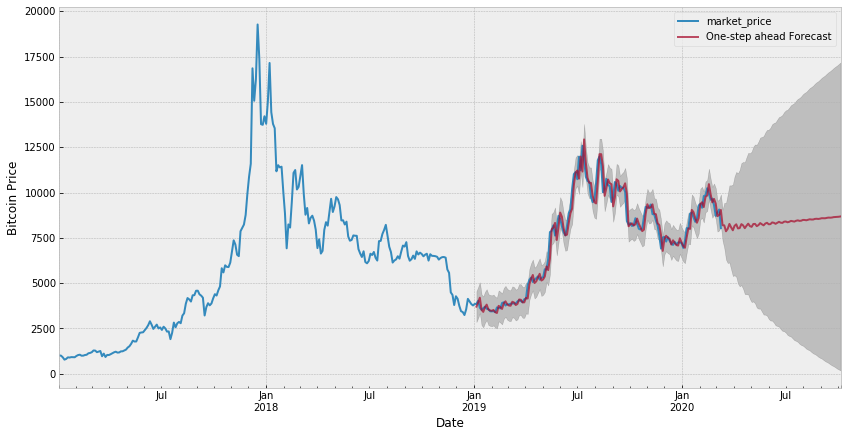

In [44]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-05'), end=pd.to_datetime('2020-10-05'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [ ]:
### PROPHET

In [50]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [52]:
plotly_df(df, title='BTC price')

In [54]:
df_prophet = df.reset_index().copy()
df_prophet.columns = ['ds', 'y']
df_prophet.tail(n=3)

,ds,y
872,2020-03-03,8912.82
873,2020-03-06,9067.39
874,2020-03-09,8039.38


In [55]:
prediction_size = 30
train_df = df_prophet[:-prediction_size]
train_df.tail(n=3)

,ds,y
842,2019-12-04,7296.77
843,2019-12-07,7547.19
844,2019-12-10,7337.42


In [56]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [57]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
872,2020-01-07
873,2020-01-08
874,2020-01-09


In [58]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
872,2020-01-07,7679.023829,5981.923906,10539.713788,7676.611956,7682.829446,519.874676,519.874676,519.874676,-27.517705,-27.517705,-27.517705,547.392381,547.392381,547.392381,0.0,0.0,0.0,8198.898505
873,2020-01-08,7679.613620,5945.133038,10492.069343,7676.910308,7683.650017,543.911755,543.911755,543.911755,22.999792,22.999792,22.999792,520.911963,520.911963,520.911963,0.0,0.0,0.0,8223.525375
874,2020-01-09,7680.203410,5974.464686,10563.895450,7677.036151,7684.809157,483.890932,483.890932,483.890932,-10.946823,-10.946823,-10.946823,494.837755,494.837755,494.837755,0.0,0.0,0.0,8164.094342


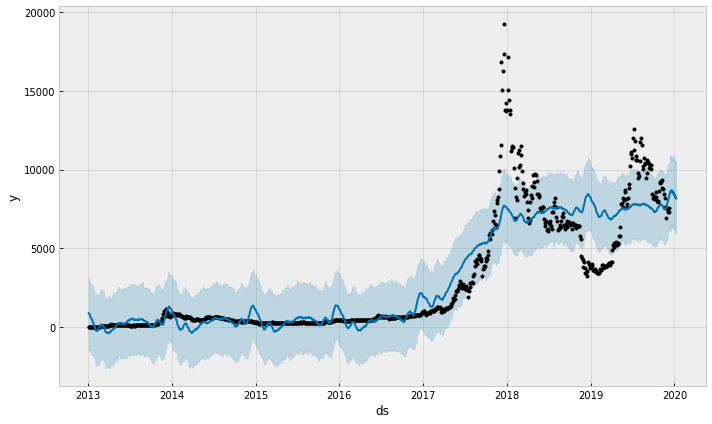

In [59]:
m.plot(forecast);

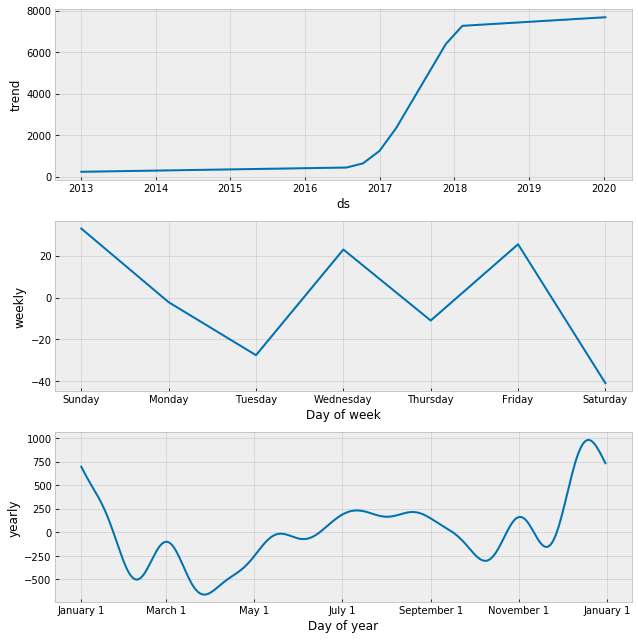

In [60]:
m.plot_components(forecast);

In [61]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [62]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))


In [63]:
cmp_df = make_comparison_dataframe(df_prophet, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-01-07,8198.898505,5981.923906,10539.713788,NaN
2020-01-08,8223.525375,5945.133038,10492.069343,NaN
2020-01-09,8164.094342,5974.464686,10563.895450,8042.65


In [64]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [66]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 16.605326889587765
MAE 1193.7842080371108


In [70]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#ff0000"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="#ff0000"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'BTC forecast')

In [71]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [72]:
train_df2 = train_df.copy().set_index('ds')

In [73]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [74]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column],
                                       lambda_prophet)

In [76]:
cmp_df2 = make_comparison_dataframe(df_prophet, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
     print(err_name, err_value)

MAPE 24.264761408132323
MAE 1744.8161677593096


In [77]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')